In [404]:
'''
Credit goes to Mr. Georgio for creating the very helpful modules used in this file.
'''

'\nCredit goes to Mr. Georgio for creating the very helpful modules used in this file.\n'

### Imports and table functions

In [405]:

from pyscf import gto,scf, cc
import numpy as np
import pyscf
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import basis_set_exchange as bse
from FcMole import FcM, FcM_like
from AP_class import APDFT_perturbator as AP
from alch_deriv import first_deriv_elec,DeltaV
from scipy.optimize import curve_fit
import numpy.fft as fft
from scipy.signal import find_peaks


In [406]:
def generate_table(data):
    # Determine the maximum width of each column
    column_widths = [max(len(str(row[i])) for row in data) for i in range(len(data[0]))]

    # Generate the table header
    table = generate_table_row(data[0], column_widths)
    table += generate_table_row(['-' * width for width in column_widths], column_widths)

    # Generate the table rows
    for row in data[1:]:
        table += generate_table_row(row, column_widths)

    return table

def generate_table_row(row_data, column_widths):
    row = '|'
    for i, item in enumerate(row_data):
        row += f' {str(item):{column_widths[i]}} |'
    row += '\n'
    return row

def get_free_energy(mol_i, n):
    return -0.5*np.sum(mol_i.atom_charges()**n)

def new_mol(mol_i,n,l_i, l_f, left_right = None):
    
    if left_right == 'L':
        mol = FcM_like(mol_i,fcs=[[1,2],[-l_i,l_f]])
    
    else:
        mol = FcM_like(mol_i,fcs=[[0,1],[-l_i,l_f]])
 
    mf_mol=scf.RKS(mol)
    mf_mol.xc="PBE0"
    mf_mol.verbose = 0
    Te_mol=mf_mol.scf(dm0=mf_mol.init_guess_by_1e())
    elec_energy = round(mf_mol.energy_elec()[0],3)
    
    return [mol, mf_mol, elec_energy, get_free_energy(mol,n)]

def d_Z_lambda(mol_i, mol_f,n,lam):
    Z_i = np.array(mol_i.atom_charges())
    Z_f = np.array(mol_f.atom_charges())
    num = (1/n)* (Z_f**n - Z_i**n)
    den = ((Z_i**n) + lam*(Z_f**n - Z_i**n))**(1 - 1/n)
    return num / den

def Z_diff(mol_i, mol_f):
    Z_i = np.array(mol_i.atom_charges())
    Z_f = np.array(mol_f.atom_charges())
    return Z_f - Z_i

def AG(mf,sites=[0,1]):
    grads=[]
    for site in sites:
        grads.append(first_deriv_elec(mf,DeltaV(mf.mol,[[site],[1]])))
    return np.array(grads)

def get_pred(mol_i,AG_i, n,e_i,l_i,l_f):
    '''Returns the linear Z and non linear Z prediction 
    from mol_i using its alchemical grad and energy
    at specific perturbation l_i, l_f at the individual atoms
    
    Caution: l_i = l_f to increase and decrease nuclear charge by same amount in 2 atoms.
    Observe the negative sign.
    '''
    
    mol = FcM_like(mol_i,fcs=[-l_i,l_f])
    return np.round([e_i + np.dot(Z_diff(mol_i,mol), AG_i),e_i + np.dot(d_Z_lambda(mol_i,mol,n,0), AG_i)],3) 

In [407]:
'''wrapper function for generating data'''
def get_symmetric_change_data(min_lam,max_lam, gen=False):
    if gen:
        frac_energies = []
        free_energies = []
        i = min_lam
        while round(i,3) <= max_lam:
            mol_props = new_mol(NN,7/3, i,i)
            e_mol = mol_props[2]
            free_e = mol_props[3]
            frac_energies.append(e_mol)
            free_energies.append(free_e)
            i  += 0.1
        frac_energies = np.array(frac_energies)
        free_energies = np.array(free_energies)
        np.savetxt(f"data/dft_0_to_{max_lam}.csv",[frac_energies,free_energies])
        
    return np.loadtxt(f'data/dft_0_to_{max_lam}.csv') 
    
def get_asymmetric_change_data(min_lam,max_lam, gen=False):
    if gen:
        R_NN = gto.M(atom= f"N 0 0 0; N 0 0 {d}; H 0 0 {d+s}",unit="Bohr",charge=1,basis='unc-ccpvdz')
        L_NN = gto.M(atom= f"H 0 0 {-s}; N 0 0 0; N 0 0 {d}",unit="Bohr",charge=1,basis='unc-ccpvdz')
        # can protonate in the nearby atom and the far atom
        R_atom_p = []
        L_atom_p = []
        i = min_lam
        
        while round(i,3) <= max_lam:
            mol_props_R = new_mol(R_NN,7/3, i,i,left_right='R')
            e_mol_R = mol_props_R[2]
            R_atom_p.append(e_mol_R)
            
            mol_props_L = new_mol(L_NN,7/3, i,i,left_right='L')
            e_mol_L = mol_props_L[2]
            L_atom_p.append(e_mol_L)
            
            i  += 0.1
        np.savetxt(f"data/prot_0_to_{max_lam}.csv",[R_atom_p,L_atom_p])
    
    return np.loadtxt(f'data/prot_0_to_{max_lam}.csv')

def gen_data(mol,AG,n,e_mol,l_i, l_f):
    l_pre = []
    nl_pre = []
    for i in np.linspace(l_i,l_f, steps + 1):
        pre = get_pred(mol, AG,n, e_mol, i,i)
        l_pre.append(pre[0])
        nl_pre.append(pre[1])
    return np.array(l_pre), np.array(nl_pre)

In [408]:
'''Stat functions'''
# least chi squared function
def chi_sq(y,y_pred):
    return np.sum((y-y_pred)**2)

# Rootmean square error
def rmse(y,y_pred):
    return np.sqrt(np.sum((y-y_pred)**2)/len(y))

# max error
def max_error(y,y_pred):
    return np.max(np.abs(y-y_pred))

# mean absolute error
def mae(y,y_pred):
    return np.sum(np.abs(y-y_pred))/len(y)

# standard deviation
def std(y,y_pred):
    return np.sqrt(np.sum((y-y_pred)**2)/(len(y)-1))


### Defining my molecules

In [409]:
# uncontracted cc-pvdz
d = 2.1
NN = gto.M(atom= f"N 0 0 0; N 0 0 {d}",unit="Bohr",basis='unc-ccpvdz')
mf_NN, e_NN = new_mol(NN, 7/3, 0,0)[1],new_mol(NN,7/3, 0,0)[2]  
CO, mf_CO, e_CO = new_mol(NN, 7/3, 1,1)[:3] 
BF, mf_BF, e_BF = new_mol(NN, 7/3, 2,2) [:3] 

e_BeNe, e_LiNA,e_HeMg, e_HAl, e_Si = new_mol(NN,7/3,3,3)[2],new_mol(NN,7/3,4,4)[2], new_mol(NN,7/3,5,5)[2],\
                                    new_mol(NN,7/3,6,6)[2],new_mol(NN,7/3,7,7)[2]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyscf/gto/mole.py:1213: UserWarning: Function mol.dumps drops attribute with_rinv_at_nucleus because it is not JSON-serializable
  warnings.warn(msg)


In [410]:
'''Data for max_lambda = 5 and = 7 is stored in data folder'''
## Calculating actual fractional charge energies
max_lam = 7
gen = False
data = get_symmetric_change_data(0,max_lam,gen)
frac_energies,free_energies =  data[0], data[1]

In [411]:
'''getting / generating data for protonation'''
s = 0.94 # 0.5 angstroms or 0.94 Bohr.
gen = False
data = get_asymmetric_change_data(0,max_lam, gen)
R_NN,L_NN = data[0],data[1]

In [434]:
'''fact checking'''
s = 0.94
ex = gto.M(atom= f"N 0 0 0; N 0 0 {d}; H 0 0 {d+s}",unit="Bohr",charge=1,basis='unc-ccpvdz')
mol_props_R = new_mol(ex,7/3, 7,7,left_right='R')
e_mol_R = mol_props_R[2]
mol_props_R[0].atom_charges()

new_ex = FcM_like(ex,fcs=[[0,1],[-7,7]])

mf_mol=scf.RKS(new_ex)
mf_mol.xc="PBE0"
mf_mol.verbose = 0
Te_mol=mf_mol.scf(dm0=mf_mol.init_guess_by_1e())
elec_energy = round(mf_mol.energy_elec()[0],3)
elec_energy

# mol_props_R = new_mol(ex,7/3, 7,7,protonate=True,left_right='R')
# mol_props_R[2]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyscf/gto/mole.py:1213: UserWarning: Function mol.dumps drops attribute with_rinv_at_nucleus because it is not JSON-serializable
  warnings.warn(msg)


-300.453

In [413]:
R_NN[-1], L_NN[-1]

(-300.453, -292.453)

### Gradients between NN and CO and BF

In [414]:
# Evaluating the linearized energy gradient at lambda = 0 with n = 7/3
lam = 0

AG_NN = AG(mf_NN) # the alchemical gradient i.e. d_E / d_Z_I
AG_CO = AG(mf_CO)
AG_BF = AG(mf_BF)

In [415]:
'''Preparing prediction data for plotting for symmetrical alchemical changes for n = 7/3'''
steps = max_lam * 10 # ensures a 0.1 step size    
pre_NN_l, pre_NN_nl = gen_data(NN,AG_NN,7/3,e_NN,0, max_lam)
pre_CO_l, pre_CO_nl = gen_data(CO,AG_CO,7/3,e_CO,-1, max_lam -1)
pre_BF_l, pre_BF_nl = gen_data(BF,AG_BF,7/3,e_BF,-2, max_lam -2)
prediction_7_3 = np.array([pre_NN_nl, pre_CO_nl, pre_BF_nl])

In [416]:
'''
Preparing prediction data for plotting for symmetrical alchemical changes for n in (0.5, 3) in steps of 0.1'''
'''
Structure of predictions_n:
    predictions_n = [...,[pre_NN_nl_n, pre_CO_nl_n, pre_BF_nl_n],...]
    pre_NN_nl_n = prediction over all lambda at n
'''
predictions_n = []
for n in np.linspace(0.5,5,46):
    pre_NN_nl_n = gen_data(NN,AG_NN,n,e_NN,0, max_lam)[1]
    pre_CO_nl_n = gen_data(CO,AG_CO,n,e_CO,-1, max_lam -1)[1]
    pre_BF_nl_n = gen_data(BF,AG_BF,n,e_BF,-2, max_lam -2)[1]
    predictions_n.append(np.array([pre_NN_nl_n, pre_CO_nl_n, pre_BF_nl_n]))
predictions_n = np.array(predictions_n)
# append numpy array with another array
# predictions_n = np.append(predictions_n, np.array([pre_NN_nl, pre_CO_nl, pre_BF_nl]), axis = 0)

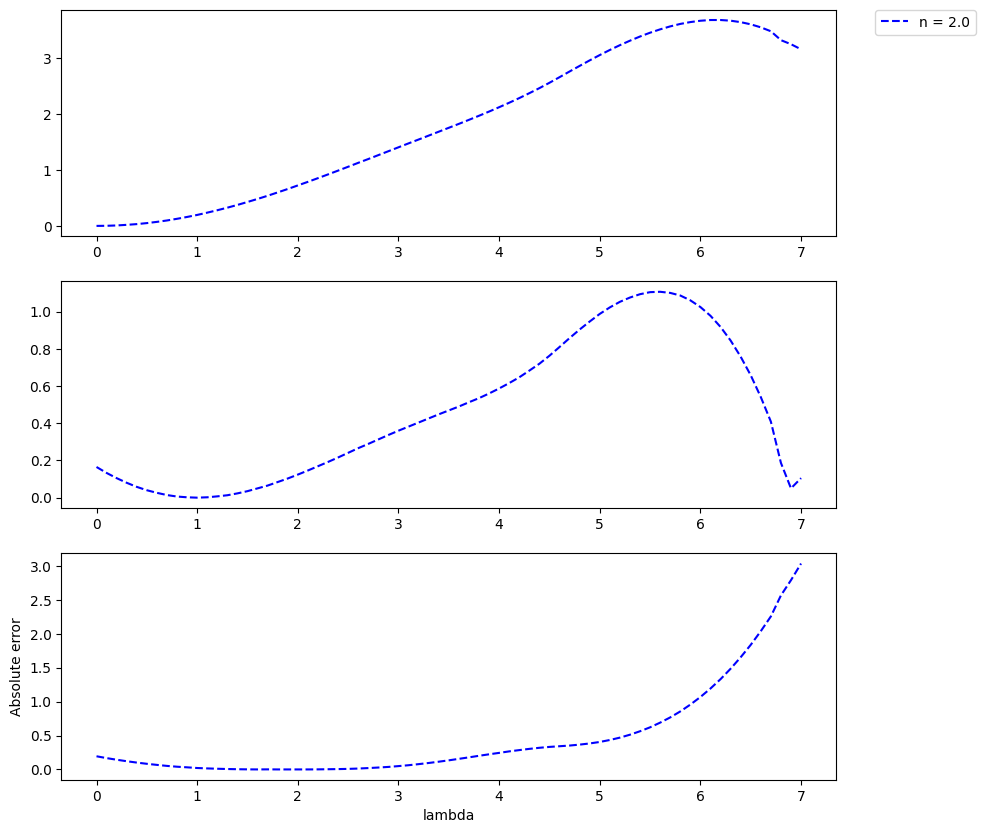

In [417]:
# plotting error between frac_energies and predictions_n 
# Suggests that we should decrease the power to about 2.0 corresp to k = 15
fig, (ax1, ax2,ax3) = plt.subplots(3,1, figsize = (10,10))
x_axis = np.linspace(0,max_lam,steps + 1)
for k in range(len(predictions_n)):
    if k == 15:
        ax1.plot(x_axis,np.abs(frac_energies - predictions_n[k][0]),'b--',label=f'n = {round(0.5 + k*0.1,2)}')
        ax2.plot(x_axis,np.abs(frac_energies - predictions_n[k][1]),'b--',label=f'n = {round(0.5 + k*0.1,2)}')
        ax3.plot(x_axis,np.abs(frac_energies - predictions_n[k][2]),'b--',label=f'n = {round(0.5 + k*0.1,2)}')
    # else:
    #     ax1.plot(x_axis,np.abs(frac_energies - predictions_n[k][0]),label=f'n = {round(0.5 + k*0.1,2)}')
    #     ax2.plot(x_axis,np.abs(frac_energies - predictions_n[k][1]),label=f'n = {round(0.5 + k*0.1,2)}')
    #     ax3.plot(x_axis,np.abs(frac_energies - predictions_n[k][2]),label=f'n = {round(0.5 + k*0.1,2)}')
        
# plotting the n = 7/3 quad errors

# ax1.plot(x_axis,np.abs(frac_energies - prediction_7_3[0]),label=f'n = {round(7/3,2)}', color = 'black', linewidth = 2)
# ax2.plot(x_axis,np.abs(frac_energies - prediction_7_3[1]),label=f'n = {round(7/3,2)}', color = 'black', linewidth = 2)
# ax3.plot(x_axis,np.abs(frac_energies - prediction_7_3[2]),label=f'n = {round(7/3,2)}', color = 'black', linewidth = 2)

plt.xlabel("lambda")
plt.ylabel("Absolute error")
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

Text(0.5, 0.98, 'Errors for different n where $Z(\\lambda) = (Z_i^n + \\lambda (Z_f^n-Z_i^n))^{\\frac{1}{n}}$')

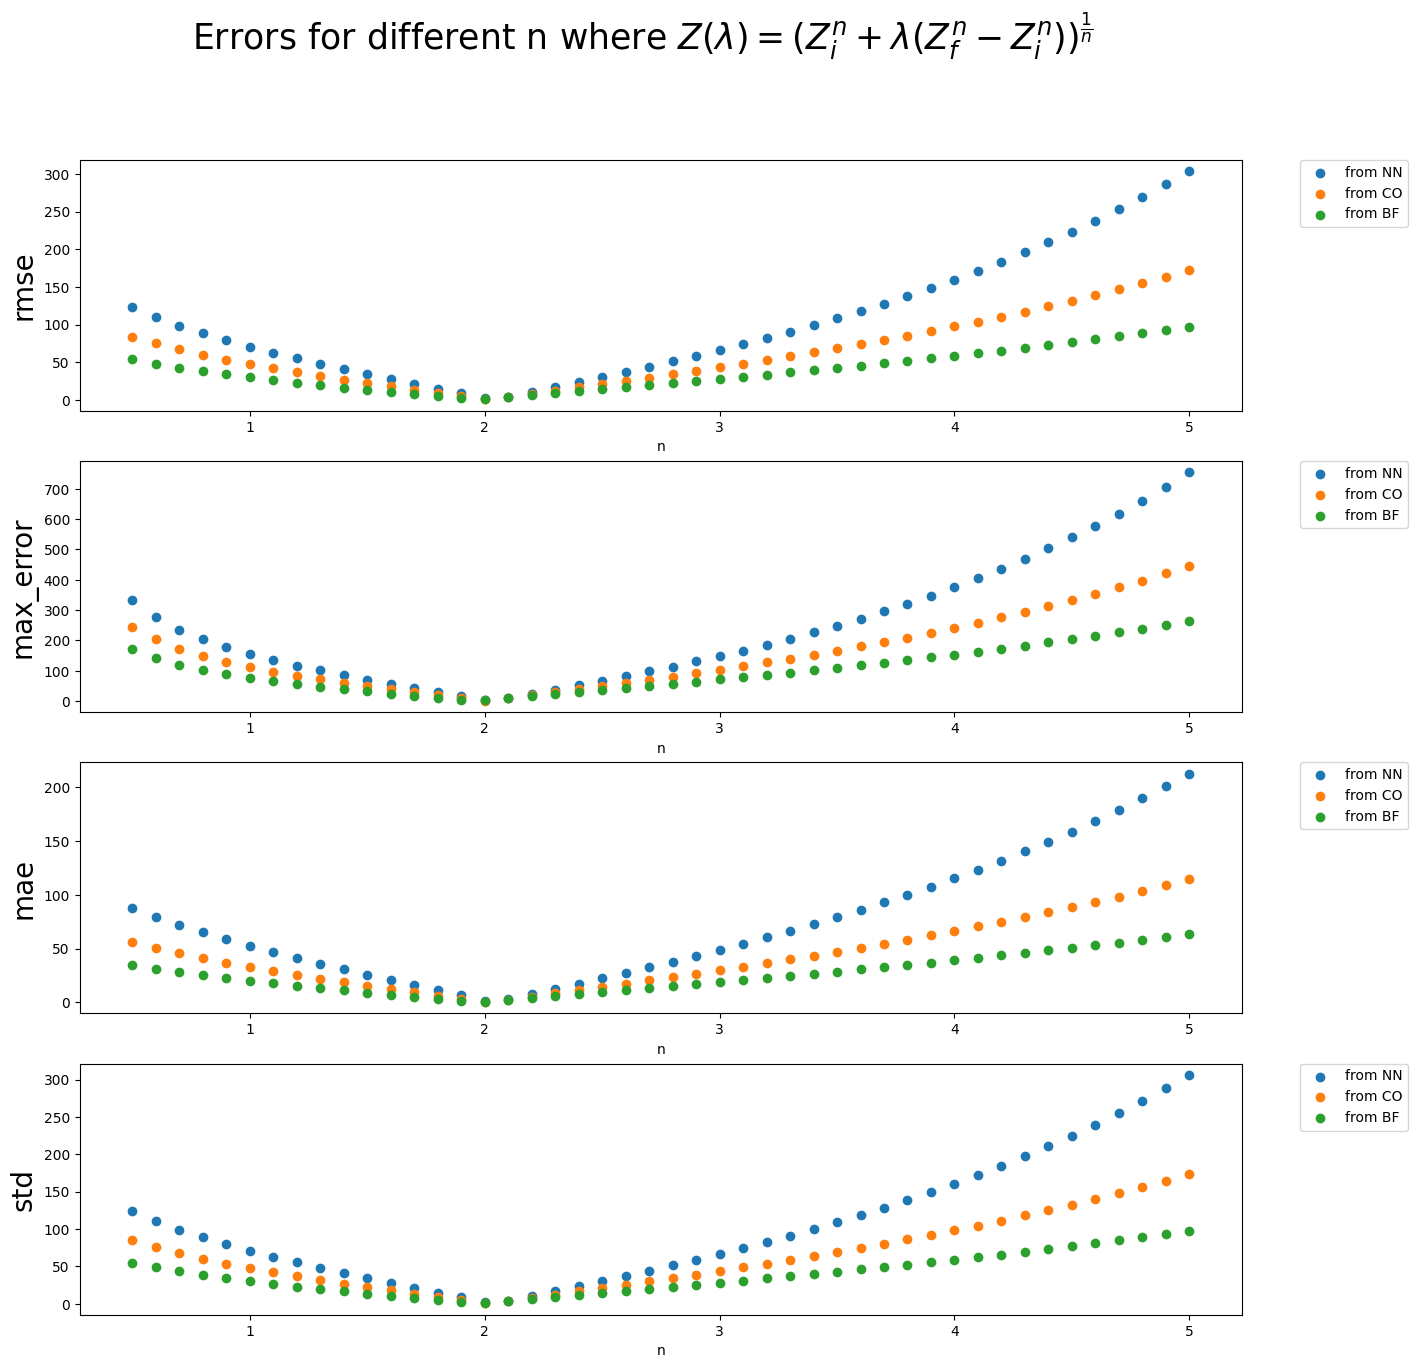

In [418]:
'''PLotting all the errors w.r.t. to n'''
error_funcs = [rmse, max_error, mae, std]
all_errors = []
for f in error_funcs:
    error = []
    for k in range(len(predictions_n)):
        # k accesses the predictions related to n = 0.5 + k*0.1
        # 0, 1, 2 accesses the NN, CO, BF predictions respectively
        # store errors in a list
        error.append(f(frac_energies,predictions_n[k][0]))
        error.append(f(frac_energies,predictions_n[k][1]))
        error.append(f(frac_energies,predictions_n[k][2]))
    all_errors.append(np.array(error))

# plot errors
fig, (ax1, ax2,ax3, ax4) = plt.subplots(4,1, figsize = (15,15))
n_axis = np.linspace(0.5,5,46)
axes = [ax1, ax2, ax3, ax4]
for i in range(len(axes)):
    axes[i].scatter(n_axis,all_errors[i][0::3],label='from NN')
    axes[i].scatter(n_axis,all_errors[i][1::3],label='from CO')
    axes[i].scatter(n_axis,all_errors[i][2::3],label='from BF')
    axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axes[i].set_xlabel("n")
    axes[i].set_ylabel(error_funcs[i].__name__)
    axes[i].yaxis.label.set_size(20)
# set title for whole figure
fig.suptitle(r'Errors for different n where $Z(\lambda) = (Z_i^n + \lambda (Z_f^n-Z_i^n))^{\frac{1}{n}}$', fontsize=25)

In [419]:
'''Fititng quadratic errors'''
def fit(x, a, b, c):
    return a*(x-b)**2 + c

quad_err = frac_energies - prediction_7_3
x_axis = np.linspace(0,max_lam,steps + 1)

popt_NN, pcov_NN = curve_fit(fit, x_axis, quad_err[0],absolute_sigma=True)
fitted_err_NN = np.array(fit(x_axis, *popt_NN))

popt_CO, pcov_CO = curve_fit(fit, x_axis, quad_err[1],absolute_sigma=True)
fitted_err_CO = np.array(fit(x_axis, *popt_CO))

popt_BF, pcov_BF = curve_fit(fit, x_axis, quad_err[2],absolute_sigma=True)
fitted_err_BF = np.array(fit(x_axis, *popt_BF))

quad_adjusted_prediction = prediction_7_3 +np.array([fitted_err_NN, fitted_err_CO, fitted_err_BF])

In [420]:
'''Fititng quartic error'''
def quart_fit(x, a, b, c,d,e):
    return a*x**4 + b*x**3 + c*x**2 + d*x + e

quart_err = frac_energies - quad_adjusted_prediction
popt_NN, pcov_NN = curve_fit(quart_fit, x_axis, quart_err[0],absolute_sigma=True)
q_fitted_err_NN = np.array(quart_fit(x_axis, *popt_NN))

popt_CO, pcov_CO = curve_fit(quart_fit, x_axis,  quart_err[1],absolute_sigma=True)
q_fitted_err_CO = np.array(quart_fit(x_axis, *popt_CO))

popt_BF, pcov_BF = curve_fit(quart_fit, x_axis,  quart_err[2],absolute_sigma=True)
q_fitted_err_BF = np.array(quart_fit(x_axis, *popt_BF))

quart_adjusted_prediction = quad_adjusted_prediction +np.array([q_fitted_err_NN, q_fitted_err_CO, q_fitted_err_BF])

### issue in fitting here

/var/folders/qy/_rg_prqx1kn6x4b6bg336mk40000gn/T/ipykernel_45279/3302026886.py:3: RuntimeWarning: divide by zero encountered in power
  return x**b + x*A*np.sin(f*x + p)


0.9772372209558107

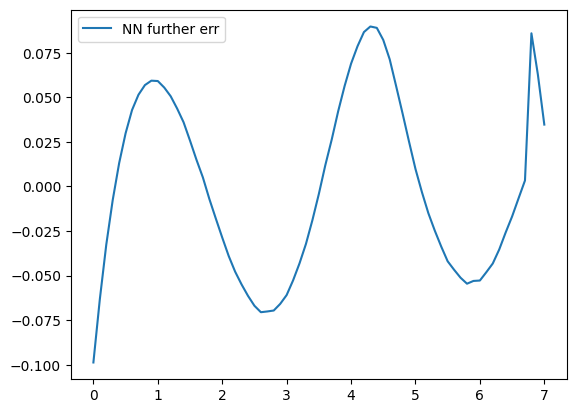

In [421]:
'''fitting further error'''
def power_sine(x, b,A, f, p):
    return x**b + x*A*np.sin(f*x + p)
x_axis = np.linspace(0,max_lam,steps + 1)
further_err = frac_energies - quart_adjusted_prediction
poo = [ 0.01, .03054518,  1.4933,  1.14250962]
popt_NN, pcov_NN = curve_fit(power_sine, x_axis, further_err[0],p0=poo,absolute_sigma=True)
fitted_err_NN = np.array(power_sine(x_axis, *popt_NN))

# popt_CO, pcov_CO = curve_fit(power_sine, x_axis,  further_err[1],absolute_sigma=True)
# q_fitted_err_CO = np.array(power_sine(x_axis, *popt_CO))

# popt_BF, pcov_BF = curve_fit(power_sine, x_axis,  further_err[2],absolute_sigma=True)
# q_fitted_err_BF = np.array(power_sine(x_axis, *popt_BF))
app = np.array(power_sine(x_axis, *poo))
plt.plot(x_axis, further_err[0],label='NN further err')
# plt.plot(x_axis, app,label='app')
# plt.plot(x_axis, further_err[1])
# plt.plot(x_axis, further_err[2])
# plt.plot(x_axis, fitted_err_NN)
# plt.plot(x_axis, q_fitted_err_CO)
# plt.plot(x_axis, q_fitted_err_BF)
plt.legend()
power_sine(0.1,*poo)
0.1**0.01

/var/folders/qy/_rg_prqx1kn6x4b6bg336mk40000gn/T/ipykernel_45279/3641280332.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['NN','CO','BF','BeNe','LiNa','HeMg','HAl','Si'])


[Text(0.0, 1, 'NN'),
 Text(1.0, 1, 'CO'),
 Text(2.0, 1, 'BF'),
 Text(3.0, 1, 'BeNe'),
 Text(4.0, 1, 'LiNa'),
 Text(5.0, 1, 'HeMg'),
 Text(6.0, 1, 'HAl'),
 Text(7.0, 1, 'Si')]

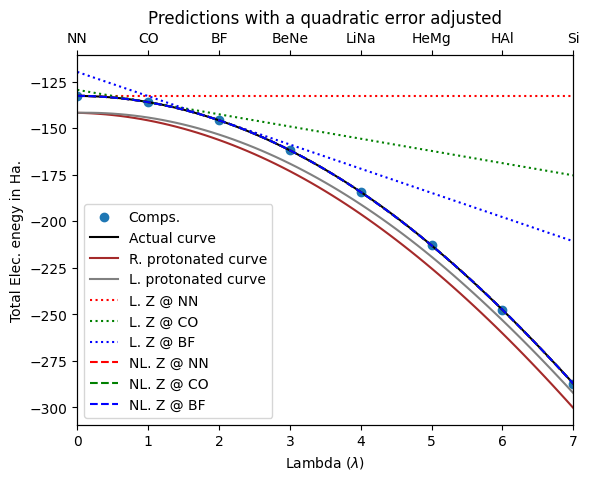

In [422]:
'''Plotting graph for symmetrical alchemical changes'''

# plotting the linearzied Z predictions
l_vals = np.array([np.array(x) for x in [pre_NN_l,pre_CO_l,pre_BF_l]])
l_keys = ['L. Z @ NN', 'L. Z @ CO','L. Z @ BF']
nl_keys = ['NL. Z @ NN','NL. Z @ CO','NL. Z @ BF']

l_lines = dict(zip(l_keys, l_vals))
nl_lines = dict(zip(nl_keys,quart_adjusted_prediction))
all_lines = {**l_lines, **nl_lines}

format = ['r:','g:', 'b:','r--','g--', 'b--']

# figure(figsize=(8, 6), dpi=80)
fig, ax = plt.subplots()
ax.scatter([0,1,2,3,4,5,6,7],[e_NN, e_CO, e_BF, e_BeNe, e_LiNA, e_HeMg, e_HAl, e_Si],label='Comps.')
ax.plot(x_axis,np.array(frac_energies),'black',label='Actual curve')
ax.plot(x_axis,np.array(R_NN),'brown',label='R. protonated curve')
ax.plot(x_axis,np.array(L_NN),'grey',label='L. protonated curve')
# ax.plot(x_axis,)
i = 0
for line in all_lines:
    # plt.scatter(np.linspace(0,2,len(lines[line])),lines[line],label=line)
    plt.plot(x_axis,all_lines[line],format[i],label=line)
    i +=1
ax.legend()
ax.set_ylabel('Total Elec. enegy in Ha.')
ax.set_xlabel(r'Lambda ($\lambda$)')
ax.set_xlim(0,7)
ax.set_title('Predictions with a quadratic error adjusted')

# add another x axis in plot
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticklabels(['NN','CO','BF','BeNe','LiNa','HeMg','HAl','Si'])

Text(0.5, 1.0, 'Error after adjusting quadratic')

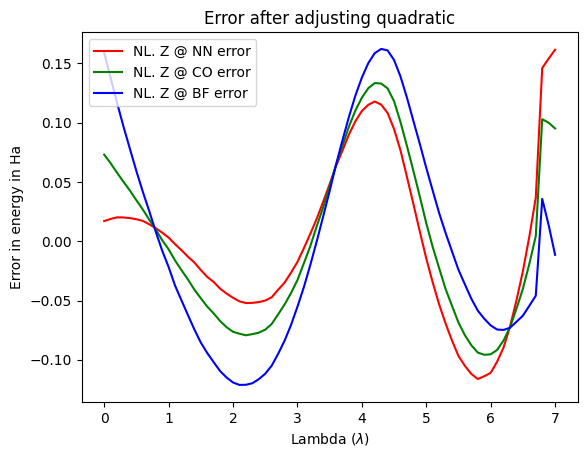

In [423]:
'''Plotting after quad error is adjusted for symmetrical alchemical changes.'''
plt.plot(x_axis, frac_energies -quad_adjusted_prediction[0],'r',label='NL. Z @ NN error')
plt.plot(x_axis, frac_energies - quad_adjusted_prediction[1],'g',label='NL. Z @ CO error')
plt.plot(x_axis, frac_energies - quad_adjusted_prediction[2],'b',label='NL. Z @ BF error')
plt.legend()
plt.xlabel(r'Lambda ($\lambda$)')
plt.ylabel('Error in energy in Ha')
plt.title('Error after adjusting quadratic')

Text(0.5, 1.0, 'After adjusting quaritc errors')

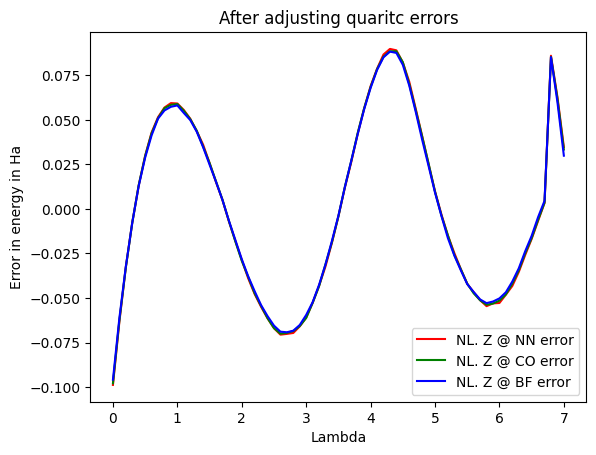

In [424]:
'''Plotting after quartic error is adjusted for symmetrical alchemical changes.'''
plt.plot(x_axis, frac_energies - quart_adjusted_prediction[0],'r',label='NL. Z @ NN error')
plt.plot(x_axis, frac_energies - quart_adjusted_prediction[1],'g',label='NL. Z @ CO error')
plt.plot(x_axis, frac_energies - quart_adjusted_prediction[2],'b',label='NL. Z @ BF error')
plt.legend()
plt.xlabel('Lambda')
plt.ylabel('Error in energy in Ha')
plt.title('After adjusting quaritc errors')

## lambda exponentiated fourier approximations

In [425]:
# fit function for variable number of terms in fourier series
def ff(lam, *args):
    A = args[0::5]
    f = args[1::5]
    p = args[2::5]
    exp = args[3::5]
    C = args[4::5]
    return sum(A[i]*lam**(exp[i]*lam) * np.sin(lam*f[i] + p[i]) + C[i] for i in range(len(C)))

# fitting the eror after adjusting quadratic error.
def get_fourier_pred(N):
    '''Gets the lambda dependent fourier prediction upto Nth order for the error after adjusting the quadratic error.'''
    fits = []
    base = (3.977507e-02,  1.83432473e+00, -1.20482758e+01,  1.16835373e-01,
            5.40220558e-03)
    for i in range(1,N):
        base += (3.977507e-02,  1.83432473e+00, -1.20482758e+01,  1.16835373e-01,
            5.40220558e-03)

    for j in range(3):
        popt, pcov = curve_fit(ff, x_axis, quart_err[j],p0=base,absolute_sigma=True,maxfev=100000)
        fits.append(ff(x_axis,*popt))
    
    return np.array(fits) + quad_adjusted_prediction

In [426]:
# f1 = np.abs(2/steps*fft.fftshift(fft.fft(quart_err[0])))
# frequencies = fft.fftfreq(steps+1,1)
# frequencies = fft.fftshift(frequencies)

# plt.plot(frequencies, f1)
# find_peaks(f1,height=0.05)
# # plt.plot(frequencies,y_dat,label='fft')
# frequencies[37]

### Calculating and plotting interaction energies / measures of models

$$\Delta_1 = E^{int}_{ele} = E^{Tot}_{ele} - \sum_{I} E^{free}_{I, ele}$$

this can be done for all $n$, where $E^{free}_{I, ele} \approx -\dfrac{1}{2}Z_I^n$

/var/folders/qy/_rg_prqx1kn6x4b6bg336mk40000gn/T/ipykernel_45279/2812728209.py:8: RuntimeWarning: invalid value encountered in power
  return sum(A[i]*lam**(exp[i]*lam) * np.sin(lam*f[i] + p[i]) + C[i] for i in range(len(C)))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Text(0.5, 1.0, '$\\Delta_1 = E^{int}_{ele} = E^{Tot}_{ele} - \\sum_{I} E^{free}_{I, ele}$')

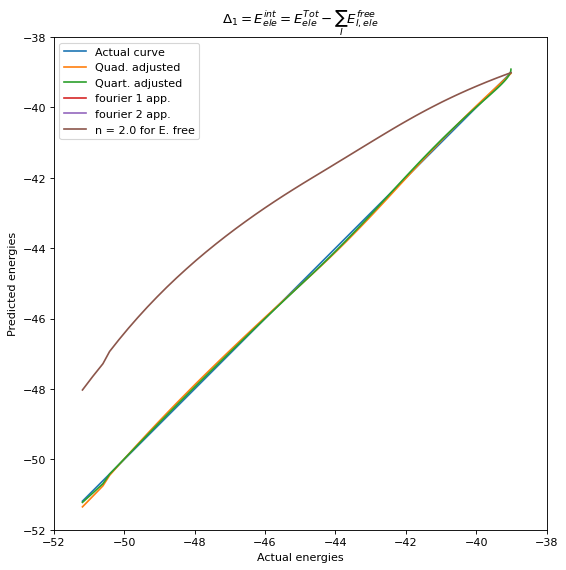

In [427]:
figure(figsize=(8, 8), dpi=80)
x_axis = frac_energies - free_energies
plt.plot(x_axis, frac_energies - free_energies, label='Actual curve')
# plt.plot(x_axis, prediction_7_3[0] - free_energies, label='P. NN')
plt.plot(x_axis, quad_adjusted_prediction[0] - free_energies, label='Quad. adjusted')
plt.plot(x_axis, quart_adjusted_prediction[0] - free_energies, label='Quart. adjusted')
plt.plot(x_axis, get_fourier_pred(1)[0] - free_energies, label='fourier 1 app.')
plt.plot(x_axis, get_fourier_pred(2)[0] - free_energies, label='fourier 2 app.')
plt.plot(x_axis, predictions_n[15][0] - free_energies, label='n = 2.0 for E. free')
plt.xlim(-52,-38)
plt.ylim(-52,-38)
plt.legend()
# set xscale equal to yscale
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('Actual energies')
plt.ylabel('Predicted energies')
plt.title(r'$\Delta_1 = E^{int}_{ele} = E^{Tot}_{ele} - \sum_{I} E^{free}_{I, ele}$')


$$\Delta_2 = E^{Tot}_{ele} / \sum_{I} E^{free}_{I, ele}$$

Text(0.5, 1.0, '$\\Delta_1 = E^{Tot}_{ele} / \\sum_{I} E^{free}_{I, ele}$')

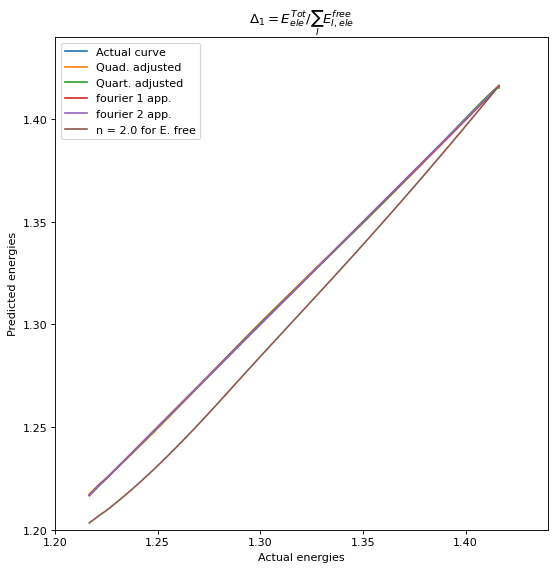

In [428]:
figure(figsize=(8, 8), dpi=80)
x_axis = frac_energies / free_energies
plt.plot(x_axis, frac_energies / free_energies, label='Actual curve')
# plt.plot(x_axis, prediction_7_3[0] / free_energies, label='P. NN')
plt.plot(x_axis, quad_adjusted_prediction[0] / free_energies, label='Quad. adjusted')
plt.plot(x_axis, quart_adjusted_prediction[0] / free_energies, label='Quart. adjusted')
plt.plot(x_axis, get_fourier_pred(1)[0] / free_energies, label='fourier 1 app.')
plt.plot(x_axis, get_fourier_pred(2)[0] / free_energies, label='fourier 2 app.')
plt.plot(x_axis, predictions_n[15][0] / free_energies, label='n = 2.0 for E. free')
plt.legend()
plt.xlim(1.2, 1.44)
plt.ylim(1.2, 1.44)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('Actual energies')
plt.ylabel('Predicted energies')
plt.title(r'$\Delta_1 = E^{Tot}_{ele} / \sum_{I} E^{free}_{I, ele}$')

$$\Delta_3 = E^{Prot.}_{ele} - E^{Tot.}_{ele}$$